In [2]:
import os
import numpy as np
from glob import glob
import tensorflow as tf
import re
import keras
from keras import layers


E0000 00:00:1747144571.965112      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [10]:


!pip freeze > requirements.txt



In [1]:
import numpy as np
import tensorflow as tf
import keras

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


E0000 00:00:1747143793.159138      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


NumPy version: 2.0.2
TensorFlow version: 2.18.0
Keras version: 3.8.0


In [14]:
save_text_file_path={}
with open("/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/prompts.txt",'r', encoding="utf-8") as f:
    for line in f:
        split_p=line.find(' ')
        save_text_file_path[line[:split_p]]=line[split_p+1:].replace("\n", "")
    f.close()


path = "/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves"
wavs = glob("{}/**/*.wav".format(path))

pattern_wav_name = re.compile(r'([^/\\\.]+)')
def get_data(wavs, id_to_text, maxlen=50):
    """returns mapping of audio paths and transcription texts"""
    data = []
    for w in wavs:
        id = pattern_wav_name.split(w)[-4]
        if len(id_to_text[id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[id]})
    return data



In [15]:
import pandas
max_target_len = 200
data = get_data(wavs, save_text_file_path, max_target_len)
df = pandas.DataFrame(data)
df['text'] = df['text'].apply(lambda x: x.lower() if isinstance(x, str) else x)
split = int(len(df) * 0.9)
df_train = df[:split]
df_val = df[split:]



In [16]:
tieng_viet="áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ"
characters = ["-", "#", "<", ">"] + [chr(i + 96) for i in range(1, 27)] + [i for i in tieng_viet] + [" ", ".", ",", "?"]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)



The vocabulary is: ['', np.str_('-'), np.str_('#'), np.str_('<'), np.str_('>'), np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_('á'), np.str_('à'), np.str_('ả'), np.str_('ã'), np.str_('ạ'), np.str_('ă'), np.str_('ắ'), np.str_('ằ'), np.str_('ẳ'), np.str_('ẵ'), np.str_('ặ'), np.str_('â'), np.str_('ấ'), np.str_('ầ'), np.str_('ẩ'), np.str_('ẫ'), np.str_('ậ'), np.str_('é'), np.str_('è'), np.str_('ẻ'), np.str_('ẽ'), np.str_('ẹ'), np.str_('ê'), np.str_('ế'), np.str_('ề'), np.str_('ể'), np.str_('ễ'), np.str_('ệ'), np.str_('ó'), np.str_('ò'), np.str_('ỏ'), np.str_('õ'), np.str_('ọ'), np.str_('ô'), np.str_('ố'), np.str_('ồ'), np.str_('ổ'), np.str_('ỗ'), np.str_('ộ'), np.str_('ơ

In [17]:
frame_length = 200
# An integer scalar Tensor. The number of samples to step.
frame_step = 80
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 256
def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wav_file)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    
   
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    
    label = char_to_num(label)
    
    return spectrogram, label

In [18]:
batch_size = 64
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["audio"]), list(df_train["text"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["audio"]), list(df_val["text"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [19]:
for batch in train_dataset.take(1):
    print(batch[1][0])
    print(batch[0][0])

tf.Tensor(
[12 34 29 98  7 12 63 18 98 20 12 33 18 98 87 18 11 98 12 59 17 98 12 78
 18 12 98 97 56 98  7 12 87 18 11 98 24 61 98 22 38 18 11 98  6 35 18 98
 15 12 64 18 11 98  6 80 98 16 88  5 98 17 32 98 15 12 64 18 11 98 16 32
 17 98  7 36 18 11 98 24 12 39 18 11 98 24 77 18 12 98 12 77 18 12  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0], shape=(129,), dtype=int64)
tf.Tensor(
[[ 5.1073065   3.7535818   0.6591053  ... -0.91270083 -0.9116397
  -0.9510356 ]
 [ 2.9512672   3.4298196   2.5577343  ... -1.0838001  -0.79143
  -0.66872513]
 [ 3.576566    3.094539    3.4078512  ... -0.73098075 -0.7650646
  -0.94606334]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(1623, 129), dtype=float32)


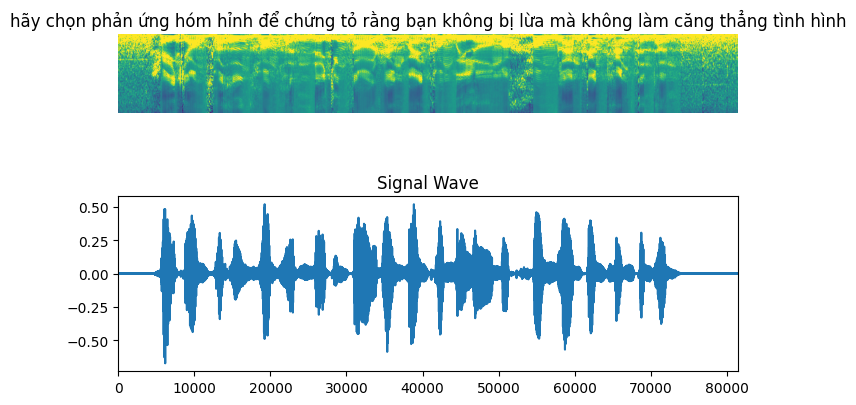

In [20]:
import matplotlib.pyplot as plt
from IPython import display

fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(df_train["audio"][0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [21]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [22]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="source")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 31],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=256 // 2 + 1,
    output_dim=102,
    rnn_units=256,
)
model.summary(line_length=110)

ValueError: The name "dense_1" is used 2 times in the model. All operation names should be unique.

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [ ]:
epochs = 60
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

In [ ]:
model.save_weights('gfgModelWeights.h5')


In [ ]:
fig = plt.figure(figsize=(8, 5))
predictions = []
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    predd = predictions[0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title('Target:'+label+'\n'+ 'Prediction:'+predd)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(df_train["audio"][0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [ ]:
import string
import unicodedata
import editdistance


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)